# Capstone Project-The Battle of Neighborhoods (Week 2)

## Table of contents
* [Part 1: Import data and data preparation ](#data)
* [Part 2: Explore Foursquare Venues](#foursquare)
* [Part 3: Clustering neighborhoods](#cluster)
* [Part 4: Visualization of selected neighborhoods](#visualization)
* [Part 5: Summary](#summary)

The goal of this notebook is to find suitable neighborhoods in Los Angeles (LA) that we are possibly to start up a gym or fitness club. For this analysis, we will use population data and location coordinates data of LA, and also venues data from Foursquare.com.

First of all, let's import libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import requests
import urllib.request
import re
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Part 1: Import data and data preparation <a name="data"></a>

#### 1.1 Neighborhoods and coordinates in LA

All 272 neighborhoods with location coordinates data was explored and download from [here](https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr).

In [2]:
# import Los Angeles Neigborhoods data
df_LA = pd.read_csv("la_neighborhoods.csv")
columns=['name','latitude','longitude']
df_LA=df_LA[columns].rename(columns={'name':'Neighborhood','latitude':'Longitude','longitude':'Latitude'})

print('There are {} neighborhoods in Los Angeles.'.format(df_LA.shape[0]))
print('The first five rows of data :')
df_LA.head()

There are 272 neighborhoods in Los Angeles.
The first five rows of data :


,Neighborhood,Longitude,Latitude
0,Acton,-118.169810,34.497355
1,Adams-Normandie,-118.300208,34.031461
2,Agoura Hills,-118.759885,34.146736
3,Agua Dulce,-118.317104,34.504927
4,Alhambra,-118.136512,34.085539


#### 1.2 Population density of neighborhoods in LA

Data scraped from website [Los Angeles Times](http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/). The purpose of using this data is to select neighborhoods we are interesed in. Since the aim of the project is to find suitable neighborhoods for open a new gym/fitness club, we can set a population density threshold to select neighborhoods in terms of higher potential members in the area.

In [3]:
URL='http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/'

def read_html_to_text(URL):
    with urllib.request.urlopen(URL) as url:
         web = url.read()

    soup = BeautifulSoup(web, 'lxml')
    data  = soup.find_all("script")[9]
    return data.text

data=read_html_to_text(URL)
info=data.split('=')[1]

# extract neighborhood names
def read_neighborhood_name(info):      
    name_list=[]
    name=re.findall(r'name:.+?,',info)
    for i in range(len(name)):
        n=name[i].split('"')[1]
        name_list.append(n)
    return name_list
    
# extract ranking and population density of each neighborhood
def read_pop_rank(info): 
    rank_list=[]
    pop_list=[]
    rank=re.findall(r"label:.+?,.+?,",info)
    for i in range(len(rank)):
        r=rank[i].split(':')[2]
        number=int(r.split('<')[0])
        rank_list.append(number)
    
        p=rank[i].split(':')[3]
        p_replace=p.replace(',','')
        pop_list.append(int(p_replace[:-1]))
    return pop_list
    
# extract total population of each neighborhood
def read_total_pop(info): 
    popu=re.findall(r'population:.+?,.+?,',info)
    total_pop_list=[]
    for i in range(len(popu)):
        n=popu[i].split('"')[1]
        total_pop_list.append(int(n.replace(',',''))) #convert str to int by remove comma in the number
    return total_pop_list
    
# save neighorboods with population density greater than 10k per sqaure mi
top_pop=[l for l in read_pop_rank(info) if l>10000]
top_neighborhood=read_neighborhood_name(info)[0:len(top_pop)]
top_total_pop=read_total_pop(info)[0:len(top_pop)]
    
# covert data into dataframe
df_top_pop=pd.DataFrame(list(zip(top_neighborhood,top_pop,top_total_pop)), columns=['Neighborhood','Population Per SQMI','Total Population'])
print ('There are {} neighborhoods in LA that have population density greater than 10k per square miles.'.format(df_top_pop.shape[0]))
df_top_pop.head()


There are 95 neighborhoods in LA that have population density greater than 10k per square miles.


,Neighborhood,Population Per SQMI,Total Population
0,Koreatown,42611,115070
1,Westlake,38214,103839
2,East Hollywood,31095,73967
3,Pico-Union,25352,42324
4,Maywood,23638,28083


Let's combine the top population dataset with LA coordinates dataset and therefore we will get a combined dataset with only 95 neighborhoods.


In [4]:
LA_subset=pd.merge(df_top_pop, df_LA, how='left',on='Neighborhood')
print('The first five rows of new dataset:')
LA_subset.head()

The first five rows of new dataset:


,Neighborhood,Population Per SQMI,Total Population,Longitude,Latitude
0,Koreatown,42611,115070,-118.304958,34.064510
1,Westlake,38214,103839,-118.272221,34.062361
2,East Hollywood,31095,73967,-118.296808,34.089109
3,Pico-Union,25352,42324,-118.284708,34.044161
4,Maywood,23638,28083,-118.187303,33.988339


Let's create a folium map of LA with labels of these 95 neighbors.

In [5]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


In [6]:
# create map of New York using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neigborhood in zip(LA_subset['Latitude'], LA_subset['Longitude'], LA_subset['Neighborhood']):
    label = '{}'.format(neigborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

## Part 2: Explore Foursquare Venues <a name="foursquare"></a>

#### 2.1 Foursquare API to get venues' information in each of the 95 neighborhoods.

In [7]:
# @hidden_cell
CLIENT_ID = '*******' # Foursquare ID
CLIENT_SECRET = '******' # Foursquare Secret
VERSION = '20200517' # Foursquare API version

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [9]:
# get venues of the 95 neighborhoods
la_venues = getNearbyVenues(names=LA_subset['Neighborhood'],
                            latitudes=LA_subset['Latitude'],
                            longitudes=LA_subset['Longitude']
                                  )

In [10]:
# Summary of venue category in each neighborhood.
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))
la_venues.groupby('Neighborhood').count().head()

There are 249 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams-Normandie,9,9,9,9,9,9
Alhambra,13,13,13,13,13,13
Arleta,4,4,4,4,4,4
Arlington Heights,28,28,28,28,28,28
Artesia,30,30,30,30,30,30


#### 2.2 Analyze Each Neighborhood

In [69]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

#Group rows by cities and by taking the mean of the frequency of occurrence of each category
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,American Restaurant,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Big Box Store,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Caribbean Restaurant,Carpet Store,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Residence Hall,College Theater,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Food Stand,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Restaurant,River,Rock Club,Russian Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Transportation Service,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Watch Shop,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adams-Normandie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Let's explore top 10 venues in each neighborhood.

In [70]:
#First, create a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
la_venues_sorted = pd.DataFrame(columns=columns)
la_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    la_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

la_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Pharmacy,Park,Playground,Grocery Store,Taco Place,Gas Station,Fast Food Restaurant,Falafel Restaurant,Farmers Market
1,Alhambra,Convenience Store,Sporting Goods Shop,Mexican Restaurant,Fast Food Restaurant,Hardware Store,Video Store,Pet Store,Pizza Place,Breakfast Spot,Bagel Shop
2,Arleta,Historic Site,Bakery,Convenience Store,Video Store,Women's Store,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
3,Arlington Heights,Korean Restaurant,Liquor Store,Latin American Restaurant,Donut Shop,Bakery,Karaoke Bar,Café,Mexican Restaurant,Music Venue,Fried Chicken Joint
4,Artesia,Indian Restaurant,Chinese Restaurant,Bubble Tea Shop,Vietnamese Restaurant,Pizza Place,Fast Food Restaurant,Gift Shop,Sandwich Place,Taiwanese Restaurant,Shopping Mall


## Part 3: Clustering neighborhoods <a name="cluster"></a>

#### 3.1 K-means clustering

We will apply the commonly used k-means algorithm to cluster neighborhoods based on their features of venues. First, need to find the best k value for clustering.

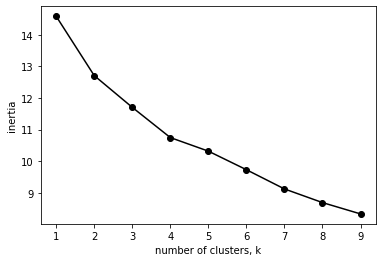

In [71]:
import matplotlib.pyplot as plt

ks = range(1, 10)
la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

inertias = []

for k in ks:
    # run k-means clustering
    cluster_models=KMeans(n_clusters=k, random_state=0)
    clustering = cluster_models.fit(la_grouped_clustering)
    
    # Append the inertia to the list of inertias
    inertias.append(cluster_models.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

There is an elbow point at k=5, let's choose k=5 for clustering.

In [72]:
# set number of clusters
kclusters = 5

la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

#### 3.2 Principal Component Analysis (PCA)

In order to plot the clustering results, we need to reduce the number of varibles of the LA clustering data and we can use PCA for the reduction. 

([<matplotlib.axis.XTick at 0x1a29e14810>,
 <a list of 10 Text xticklabel objects>)

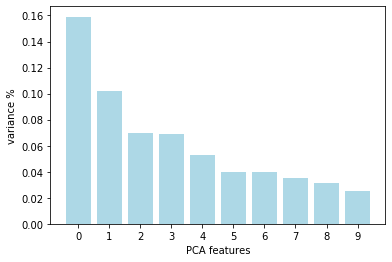

In [73]:
from sklearn.decomposition import PCA as sklearnPCA

# Create a PCA instance: pca
pca = sklearnPCA(n_components=10)
principalComponents = pca.fit_transform(la_grouped_clustering)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='lightblue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

From the chart above, the first two components explain the majority of the variance in our data.

First, let's try to plot using two PCs.

In [74]:
#transform data into 2-dimension using PCA
pca2 = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca2.fit_transform(la_grouped_clustering),columns=['PCA%i'% i for i in range(2)], index=la_grouped_clustering.index)
transformed.head()

,PCA0,PCA1
0,0.066150,-0.028311
1,-0.061471,-0.033098
2,-0.061654,-0.020089
3,-0.045791,-0.036726
4,-0.051021,-0.011013


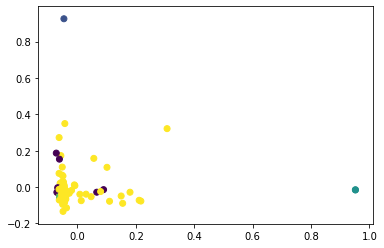

In [75]:
# plot with kmeans label
plt.scatter(transformed['PCA0'], transformed['PCA1'], c=kmeans.labels_.astype(float))

The clustering results looks reasonable from the 2D plot. But, it still has overlap of some dots. So, let's also view the clustering results using 3 PCs and 3D plot.

In [76]:
# run PCA with 3 components
pca3=sklearnPCA(n_components=3)

# store results of PCA in a data frame
pca_result=pd.DataFrame(pca3.fit_transform(la_grouped_clustering), columns=['PCA%i'% i for i in range(3)], index=la_grouped_clustering.index)

pca_result.head()

,PCA0,PCA1,PCA2
0,0.066150,-0.028311,0.008234
1,-0.061471,-0.033098,-0.011446
2,-0.061654,-0.020089,-0.009563
3,-0.045791,-0.036726,-0.011539
4,-0.051021,-0.011013,0.012032


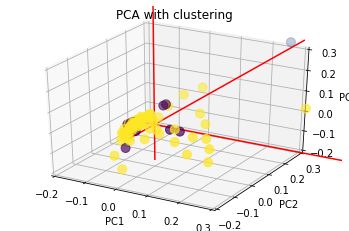

In [77]:
# 3D plotting
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(pca_result['PCA0'],pca_result['PCA1'],pca_result['PCA2'],c=kmeans.labels_.astype(float),s=80)

# make lines through spaces
x_axis = ((min(pca_result['PCA0']), max(pca_result['PCA0'])), (0, 0), (0,0))
ax.plot(x_axis[0], x_axis[1], x_axis[2], 'r')
y_axis = ((0, 0), (min(pca_result['PCA1']), max(pca_result['PCA1'])), (0,0))
ax.plot(y_axis[0], y_axis[1], y_axis[2], 'r')
z_axis = ((0, 0), (0,0), (min(pca_result['PCA2']), max(pca_result['PCA2'])))
ax.plot(z_axis[0], z_axis[1], z_axis[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA with clustering")

# change axis scale
ax.set_xlim3d(-0.2, 0.3)
ax.set_ylim3d(-0.2, 0.3)
ax.set_zlim3d(-0.2, 0.3)

plt.show()


The 3D plot is much more clear to see the separation of the all clusters.

#### 3.3 Add cluster information to the map

In [78]:
# add clustering labels
la_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_+1)

la_merged = df_LA

# merge la_grouped with toronto_data to add latitude/longitude for each neighborhood
la_merged = la_merged.join(la_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# drop rows with Cluster Labels = NA
la_merged.dropna(inplace=True)
    
la_merged['Cluster Labels']=la_merged['Cluster Labels'].astype(int)
la_merged.head() 

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adams-Normandie,-118.300208,34.031461,1,Sushi Restaurant,Pharmacy,Park,Playground,Grocery Store,Taco Place,Gas Station,Fast Food Restaurant,Falafel Restaurant,Farmers Market
4,Alhambra,-118.136512,34.085539,5,Convenience Store,Sporting Goods Shop,Mexican Restaurant,Fast Food Restaurant,Hardware Store,Video Store,Pet Store,Pizza Place,Breakfast Spot,Bagel Shop
6,Artesia,-118.080101,33.866896,5,Indian Restaurant,Chinese Restaurant,Bubble Tea Shop,Vietnamese Restaurant,Pizza Place,Fast Food Restaurant,Gift Shop,Sandwich Place,Taiwanese Restaurant,Shopping Mall
10,Arleta,-118.430757,34.243100,5,Historic Site,Bakery,Convenience Store,Video Store,Women's Store,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
11,Arlington Heights,-118.323408,34.044910,5,Korean Restaurant,Liquor Store,Latin American Restaurant,Donut Shop,Bakery,Karaoke Bar,Café,Mexican Restaurant,Music Venue,Fried Chicken Joint


In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 3.4 Explore each cluster

In [80]:
# create a function to extract top 10 venues in each cluster
def cluster_venue_total(merged_data,cluster_label):
    '''This function is going to return the total proportion of each venue category 
       across all neighborhoods in this cluster
    '''
    cluster=merged_data.loc[merged_data['Cluster Labels'] == cluster_label]
    cluster_grouped=la_grouped[la_grouped['Neighborhood'].isin(cluster['Neighborhood'])]
    
    #sum proportion for each category
    cluster_grouped_total=cluster_grouped.append(cluster_grouped.sum().rename('Total'))
    cluster_grouped_total=cluster_grouped_total.drop('Neighborhood',axis=1)
    cluster_grouped_total=cluster_grouped_total.loc['Total'].to_frame()

    cluster_grouped_total=cluster_grouped_total.sort_values(by='Total',axis=0, ascending=False)

    return cluster_grouped_total


#### Cluster 1

In [81]:
# explore cluster 1
# select the top 10 venues in cluster1
cluster_label=1
cluster1_grouped_total=cluster_venue_total(la_merged,cluster_label)
cluster1_top10=cluster1_grouped_total.iloc[0:10,:]

# show venues that are not zero
cluster1_top10[cluster1_top10['Total']!=0]

,Total
Grocery Store,1.937302
Food,0.666667
Convenience Store,0.492857
Business Service,0.476190
Sandwich Place,0.466667
Other Repair Shop,0.392857
Fast Food Restaurant,0.391667
Burger Joint,0.366667
Sushi Restaurant,0.333333
Chinese Restaurant,0.291667


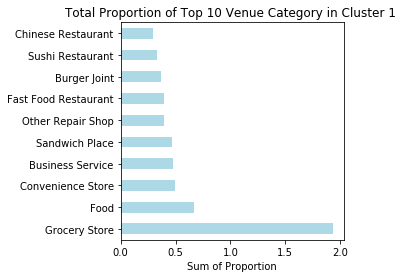

In [82]:
# visualize the results-bar chart
cluster1_top10['Total'].plot(kind='barh',figsize=(4,4),color='lightblue')
plt.xlabel('Sum of Proportion')
plt.title('Total Proportion of Top 10 Venue Category in Cluster 1 ')

plt.show()

Obviously, this cluster has various types of venues, but is mainly occupied by grocery store and sorts of food, so we can define it as grocery and food cluster.

#### Cluster 2

In [83]:
# explore cluster 2
cluster_label2=2
cluster2_grouped_total=cluster_venue_total(la_merged,cluster_label2)
cluster2_top10=cluster2_grouped_total.iloc[0:10,:]

# show venues that are not zero
cluster2_top10[cluster2_top10['Total']!=0]

,Total
Burger Joint,1.0


This cluster only has fast food.

#### Cluster 3

In [84]:
# explore cluster 3
cluster_label3=3
cluster3_grouped_total=cluster_venue_total(la_merged,cluster_label3)
cluster3_top10=cluster3_grouped_total.iloc[0:10,:]

# show venues that are not zero
cluster3_top10[cluster3_top10['Total']!=0]

,Total
Park,2.0


This cluster has only parks.

#### Cluster 4

In [85]:
# explore cluster 4
cluster_label4=4
cluster4_grouped_total=cluster_venue_total(la_merged,cluster_label4)
cluster4_top10=cluster4_grouped_total.iloc[0:10,:]

# show venues that are not zero
cluster4_top10[cluster4_top10['Total']!=0]

,Total
Speakeasy,1.0


We can define this cluster as multiple venues cluster.

#### Cluster 5

In [86]:
# explore cluster 5
cluster_label5=5
cluster5_grouped_total=cluster_venue_total(la_merged,cluster_label5)
cluster5_top10=cluster5_grouped_total.iloc[0:10,:]

# show venues that are not zero
cluster5_top10[cluster5_top10['Total']!=0]

,Total
Mexican Restaurant,5.494419
Fast Food Restaurant,3.000178
Convenience Store,2.678137
Pizza Place,2.648646
Park,2.390054
Burger Joint,2.381453
Bakery,2.061587
Food,1.920274
Home Service,1.880260
Liquor Store,1.662110


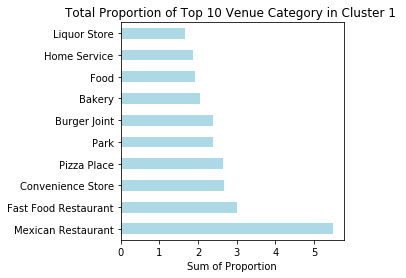

In [87]:
# visualize the results-bar chart
cluster5_top10['Total'].plot(kind='barh',figsize=(4,4),color='lightblue')
plt.xlabel('Sum of Proportion')
plt.title('Total Proportion of Top 10 Venue Category in Cluster 1 ')

plt.show()

The last cluster is resturant cluster.

Next, let's find proportion sum of venues that contain "Gym,Yoga, Fitness" in each cluster.

In [88]:
def find_gym_venue(df):
    df_new=df.copy()
    df_new.reset_index(inplace=True) # reset index
    df_new.rename(columns={'index':'Venue'},inplace=True)
    return df_new[df_new['Venue'].str.contains('Yoga|Gym|Fitness')]

In [89]:
# "Gym,Yoga, Fitness" in cluster1 
cluster1_gym=find_gym_venue(cluster1_grouped_total)
cluster1_gym

,Venue,Total
48,Yoga Studio,0.0
196,Gym,0.0
197,Gym / Fitness Center,0.0
198,Gymnastics Gym,0.0


In [91]:
# "Gym,Yoga, Fitness" in cluster5 
cluster5_gym=find_gym_venue(cluster5_grouped_total)
cluster5_gym

,Venue,Total
32,Gym,0.625155
41,Gym / Fitness Center,0.510673
67,Yoga Studio,0.268912
160,Gymnastics Gym,0.058824


Summary in this part, there is only one cluster, Cluster 5 has venues of gym and fitness center. So, we need avoid to have the new gym club set up in the neighborhoods in this cluster. 

## Part 4: Visualization of selected neighborhoods <a name="visualization"></a>

Next, we will create a Choropleth map based on the population density of the 95 neighborhoods and label the neighborhoods in selected clusters, so that we can make further decision on neighborhoods selection according to population density. The choropleth map is selected for better visualization.

In [92]:
# select data with only targeted clusters
cluster_selected=la_merged.loc[la_merged['Cluster Labels'].isin([1,2,3,4])]

# update population density dataset for generating map
df_pop_new=df_top_pop.rename(columns={'Population Per SQMI':'Density'}).drop('Total Population',axis=1)
df_pop_new.head()

,Neighborhood,Density
0,Koreatown,42611
1,Westlake,38214
2,East Hollywood,31095
3,Pico-Union,25352
4,Maywood,23638


In [93]:
#load LA neighborhoods json file for map
with open('Los Angeles Neighborhood Map.geojson') as f:
    laArea = json.load(f)

# create the choropleth map
choro_clusters_map = folium.Map(location=[latitude, longitude], tiles='Mapbox Bright', zoom_start=11)
choro_clusters_map.choropleth(geo_data=laArea, data=df_pop_new, columns=['Neighborhood', 'Density'], \
                 key_on='feature.properties.name', fill_color='YlGn', fill_opacity=0.7,line_opacity=0.2,legend_name='Population Per SQMI in the 95 neighborhoods of LA')


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_selected['Latitude'], cluster_selected['Longitude'], cluster_selected['Neighborhood'], cluster_selected['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(choro_clusters_map)
       
choro_clusters_map

## Part 5: Summary <a name="summary"></a>

From the analysis and visualization above, we can choose neighborhoods in cluster1 (purple dots in map), such as Adams-Normandie and Florence-Firestone to start the gym/fitness club business. From the Foursquare venues data and clustering analysis, we know there are no gym/fitness venues at all. Additionally, among all the neighborhoods that have no gym/fitness venues, they have relatively higher population density which might be beneficial for having more members. However, further analyses are also needed to obtain the exact location. To achieve this, we will still need to know the number of similar venues nearby the area, because the nearby neighorhoods which are located in cluster 5 might have numbers of fitness centers.